In [ ]:
# Importing required Libraries
import cv2
from scipy import ndimage
import numpy as np
from math import sqrt, pow, pi, exp
import matplotlib.pyplot as plt

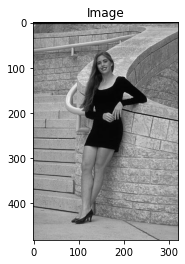

In [ ]:
# Reading the image and showing it.
I = cv2.imread('388016.jpeg', cv2.IMREAD_GRAYSCALE)
height, width = I.shape
plt.title("Image")
plt.imshow(I,cmap='gray')
plt.show()

In [ ]:
# Defining custom convolve function for a filter of size 3
def convolve_img(img, F, axis=0):
    height, width = img.shape
    # change F for convolution
    F = F[::-1]
    # We will be using a 3 dimensional linear F so we will pad the array using mirroring
    img_result = np.zeros((height, width), dtype=float)
    # Row wise convolution for filter 3 X 1
    if axis == 0:
        for i in range(0,height):
            for j in range(0, width):
                if j == 0:
                    img_result[i, j] = img[i, j] * F[0] + img[i, j] * F[1] + img[i, j + 1]* F[2]
                    continue
                if j == width-1:
                    img_result[i, j] = img[i, j-1] * F[0] + img[i, j] * F[1] + img[i, j] * F[2]
                    continue
                img_result[i, j] = img[i, j-1] * F[0] + img[i, j] * F[1] + img[i, j + 1] * F[2]
    else:
        #Column wise 1-D Convolution for filter 3 X 1
        for i in range(0, width):
            for j in range(0, height):
                if j == 0:
                    img_result[j, i] = img[j, i] * F[0] + img[j, i] * F[1] + img[j+1, i] * F[2]
                    continue
                if j == height - 1:
                    img_result[j, i] = img[j - 1, i] * F[0] + img[j, i] * F[1] + img[j, i] * F[2]
                    continue
                img_result[j, i] = img[j - 1, i] * F[0] + img[j, i] * F[1] + img[j + 1, i] * F[2]

    return img_result

# Function for Gaussian 1-D

def gaussian(size, sigma=1.0):
    rang = range(-np.int8(size / 2), np.int8(size / 2) + 1) 
    G = np.empty(size) 
    
    for i in range(0, size):
        G[i] = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-rang[i]**2/(2 * sigma**2))
    
    maximum = np.max(G)
    minimum = np.min(G)

    G = (G - minimum)/(maximum-minimum)
    return G

# Function for Derivative of Gaussian
def d_gaussian(size, sigma=1.0):
    rang = range(-np.int8(size / 2), np.int8(size / 2) + 1) 
    G = np.empty(size) 
    
    for i in range(0, size):
        G[i] = -1/(sigma * np.sqrt(2 * np.pi)) * np.exp(rang[i]/(sigma**2))
    maximum = np.max(G)
    minimum = np.min(G)

    G = (G - minimum)/(maximum-minimum)
    return G

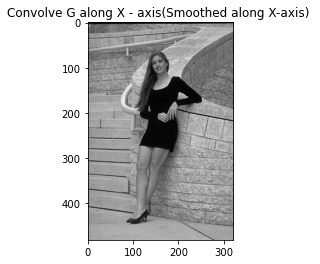

In [ ]:
# Convolve G with I along X-axis ( Smoothed along X-axis)
G = gaussian(3,3.0)
I_x = np.empty([I.shape[0],I.shape[1]])
for i in range(0,I.shape[0]): # Row wise convolution
    I_x[i,:] = np.convolve(I[i,:],G ,'same')
plt.title("Convolve G along X - axis(Smoothed along X-axis) ")
plt.imshow(I_x,cmap='gray')
plt.show()


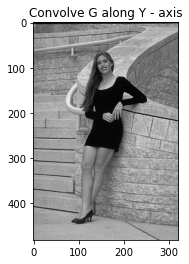

In [ ]:
# Convolve G with I along Y-axis ( Smoothed along Y-axis)
I_y = np.empty([I.shape[0],I.shape[1]])
for j in range(0,I.shape[1]): # Column wise convolution
    I_y[:,j] = np.convolve(I[:,j].reshape(-1),G,'same')
plt.title("Convolve G along Y - axis")
plt.imshow(I_y,cmap='gray')
plt.show()



In [ ]:
# Getting 1-D Derivative Gaussian filters
derivative = np.array([-1, 0, 1],np.float32)
G_x = np.convolve(G,derivative)
G_y = G_x
print(G_x)

[ 0. -1.  0.  1.  0.]


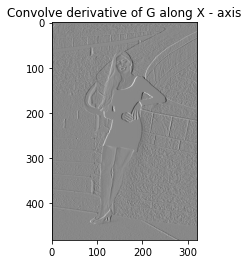

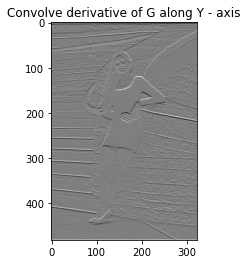

In [ ]:
# Convolve G with I along X-axis
I_x_prime = np.empty([I.shape[0], I.shape[1]])
for i in range(0,I.shape[0]):
    I_x_prime[i,:] = np.convolve(I_x[i,:],G_x,'same')
plt.title("Convolve derivative of G along X - axis")
plt.imshow(I_x_prime, cmap='gray')
plt.show()

# Convolve G with I along Y-axis
# Iy = np.empty([I.shape[0],I.shape[1]])
I_y_prime = np.empty([I.shape[0],I.shape[1]])
for j in range(0,I.shape[1]):
    I_y_prime[:,j] = np.convolve(I_y[:,j].reshape(-1),G_y,'same')
plt.title("Convolve derivative of G along Y - axis")
plt.imshow(I_y_prime,cmap='gray')
plt.show()





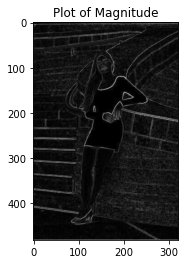

62.354024636261315


In [ ]:
# Compute M(x,y) - Magnitude
M = np.zeros((height, width))

height, width = I_x_prime.shape
for i in range(0, height, 1):
    for j in range(0, width, 1):
        M[i, j] = sqrt(pow(I_x_prime[i, j], 2) + pow(I_y_prime[i, j], 2))

# Finding the gradient
gradient_orientation = np.arctan2(I_y_prime, I_x_prime) * (180 / pi)
# from [-180 to 180]
gradient_orientation[gradient_orientation < 0] += 180

plt.title("Plot of Magnitude")
plt.imshow(M ,cmap='gray')
plt.show()

print(gradient_orientation[0,0])


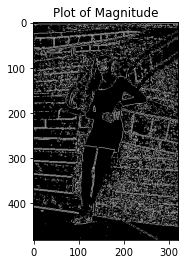

In [ ]:
# Non-Maximum Suppression

threshold_image = np.zeros(I.shape)
high_threshold_ratio = 0.5
low_threshold_ratio = 0.1
Z = np.zeros((height, width))
for i in range(1, height-1):
    for j in range(1, width-1):
        q = 255
        r = 255
        curr = gradient_orientation[i, j]
        if (0 <= curr < 22.5) or (157.5 <= curr <= 180): #Along X-axis
            q = M[i, j + 1]
            r = M[i, j - 1]
            # curr 45
        elif 22.5 <= curr < 67.5: # Dignoal Line can be thought of passing through I and III Quadrants
            q = M[i + 1, j - 1]
            r = M[i - 1, j + 1]
            # curr 90
        elif 67.5 <= curr < 112.5: # Vertical Line
            q = M[i + 1, j]
            r = M[i - 1, j]
            # curr 135
        elif 112.5 <= curr < 157.5: # Dignoal Line can be thought of passing through II and IV Quadrants
            q = M[i - 1, j - 1]
            r = M[i + 1, j + 1]

        if (M[i, j] >= q) and (M[i, j] >= r):
            Z[i, j] = M[i, j]
        else:
            Z[i, j] = 0

# double thresholding step
ids = np.zeros_like(I)
high_threshold = np.max(Z) * high_threshold_ratio
low_threshold = np.max(Z) * low_threshold_ratio 
height, width = M.shape

for i_x in range(width):
    for i_y in range(height):

        grad_mag = Z[i_y, i_x]

        if grad_mag<low_threshold:
            Z[i_y, i_x]= 0
        elif high_threshold>grad_mag>= low_threshold:
            ids[i_y, i_x]= 255
        else:
            ids[i_y, i_x]= 255


plt.title("Plot of Magnitude")
plt.imshow(ids ,cmap='gray')
plt.show()          

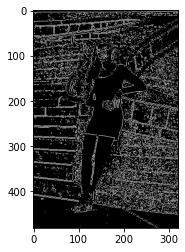

In [ ]:
# Performing Hysterisis Thresholding
weak = 20
strong = 255
for i in range(1, height-1):
    for j in range(1, width-1):
        if (ids[i,j] == weak):
            if ((ids[i+1, j-1] == strong) or (ids[i+1, j] == strong) or (ids[i+1, j+1] == strong) or (ids[i, j-1] == strong) or (ids[i, j+1] == strong)or (ids[i-1, j-1] == strong) or (ids[i-1, j] == strong) or (ids[i-1, j+1] == strong)):
                ids[i, j] = strong
            else:
                ids[i, j] = 0
plt.imshow(ids,cmap='gray')
plt.show()

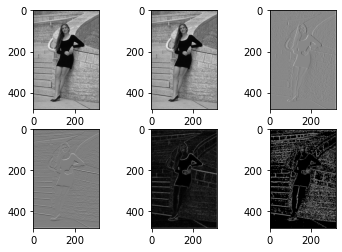

In [ ]:
#plot all in a single step

f, ax = plt.subplots(2,3) 

ax[0,0].imshow(I_x, cmap='gray')
ax[0,1].imshow(I_y, cmap='gray')
ax[0,2].imshow(I_x_prime, cmap='gray')
ax[1,0].imshow(I_y_prime, cmap='gray')
ax[1,1].imshow(M, cmap='gray')
ax[1,2].imshow(ids, cmap='gray')
plt.savefig('Final2.jpg')